# Соревнование: San Francisco Crime Classification

_Given time and location, you must predict the category of crime that occurred. Kaggle is hosting this competition for the machine learning community to use for fun and practice._

https://www.kaggle.com/c/sf-crime

##  Подготовка работы. Загрузка библиотек и настройка отображения
Импорты и настроийки, которые необходимы для шаблона.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

%matplotlib inline

## Загрузка, очистка данных.

Загрузка тренировочных данных из csv:

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv', index_col='Id')

In [4]:
feature_columns_to_use = ['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y']

In [5]:
data = train_data[feature_columns_to_use].append(test_data[feature_columns_to_use])

In [6]:
from collections import defaultdict
from sklearn.decomposition import PCA

def get_streets(street):
    if street.find('/') != -1:
        return map(str.strip, street.split('/'))
    pos = street.find('Block of ')
    if pos != -1:        
        return [street[pos+9:]]    
    return [street]

def is_corner(addr):
    streets = get_streets(addr)
    if len(list(streets))>1:
        return 1
    return 0

def addr_to_street(addr):
    streets = get_streets(addr)
    return '_'.join(streets)

In [7]:
data['Corner'] = data.Address.apply(is_corner)
data['Street'] = data.Address.apply(addr_to_street)

In [8]:
nonnumeric_columns = ['DayOfWeek','PdDistrict','Address','Street']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in nonnumeric_columns:
    data["{}_Conv".format(feature)] = le.fit_transform(data[feature])

In [9]:
cat_conv = LabelEncoder()
train_data['Category'] = cat_conv.fit_transform(train_data['Category'])

In [10]:
def convert_time(data):
    data['Min'] = data.Dates.apply(lambda x: x.minute)
    data['Hour'] = data.Dates.apply(lambda x: x.hour)
    data['Day'] = data.Dates.apply(lambda x: x.day)
    data['Month'] = data.Dates.apply(lambda x: x.month)
    data['Year'] = data.Dates.apply(lambda x: x.year)
    data['WeekNumber'] = data.Dates.apply(lambda x: x.isocalendar()[1])
    return data

data.Dates = pd.to_datetime(data.Dates)
data = convert_time(data)

In [39]:
# построим сетку net_size*net_size и вернем индекс
def net_cell(x, y, x_min, x_max, y_min, y_max, net_size):
    x_c = int((x-x_min)/(x_max-x_min)*(net_size-1))
    y_c = int((y-y_min)/(y_max-y_min)*(net_size-1))
    return y_c*net_size+x_c

In [40]:
x_min, x_max, y_min, y_max = np.min(data.X), np.max(data.X), np.min(data.Y), np.max(data.Y)
net_size = 75
data['Cell'] = data[['X', 'Y']].apply(lambda x: net_cell(x[0], x[1], x_min, x_max, y_min, y_max, net_size),axis=1)

## Построение модели

In [42]:
def prepare_data(data, train_data, feature_columns, eval_week=10):
    train_X = data[feature_columns][0:train_data.shape[0]][data[0:train_data.shape[0]].WeekNumber % eval_week != 0].as_matrix()
    eval_X = data[feature_columns][0:train_data.shape[0]][data[0:train_data.shape[0]].WeekNumber % eval_week == 0].as_matrix()

    test_X = data[feature_columns][train_data.shape[0]::].as_matrix()

    train_y = train_data[data[0:train_data.shape[0]].WeekNumber % eval_week != 0]['Category']
    eval_y = train_data[data[0:train_data.shape[0]].WeekNumber % eval_week == 0]['Category']
    
    return train_X, eval_X, test_X, train_y, eval_y

In [43]:
import xgboost as xgb

def run_xgb(train_X, eval_X, test_X, train_y, eval_y,
            max_depth=10, n_estimators=1000, learning_rate=0.05,
            early_stopping_rounds=10, seed=42):
    
    start_time = datetime.datetime.now()

    gbm = xgb.XGBClassifier(max_depth=max_depth,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            nthread=4,
                            seed=seed,
                            silent=False).fit(train_X, train_y,
                                             eval_metric='mlogloss',
                                             eval_set=[(eval_X, eval_y)],
                                             early_stopping_rounds=early_stopping_rounds,
                                             verbose=True
                                             )

    duration = (datetime.datetime.now() - start_time).total_seconds()
    print('Time elapsed: {0}'.format(duration))
    
    return gbm

In [44]:
def get_predictions(model, test_X):
    predictions = model.predict_proba(test_X)
    return np.split(predictions, 2, axis=1)[1].T

In [45]:
def save_predicts(name, predictions, index, columns, float_format='%.6f'):
    df = pd.DataFrame(predictions, index=index, columns=columns)
    df.index.name = 'Id'
    df.to_csv('./output/{}.csv.gz'.format(name), compression='gzip', float_format=float_format)

In [46]:
from sklearn.externals import joblib

def save_model(name, model):    
    out = joblib.dump(model, 'models/{}.pkl'.format(name)) 

In [47]:
feature_columns = ['Min', 'Hour', 'Day', 'Month', 'Year',
                   'DayOfWeek_Conv', 'PdDistrict_Conv', 'Address_Conv', 'X', 'Y',
                   'Corner', 'Street_Conv', 'Cell']

train_X, eval_X, test_X, train_y, eval_y = prepare_data(data, train_data,
                                                        feature_columns, eval_week=7)

gbm = run_xgb(train_X, eval_X, test_X, train_y, eval_y, max_depth=12,
               n_estimators=1000, learning_rate=0.05, early_stopping_rounds=15,
               seed=15)

predictions = get_predictions(gbm, test_X)
save_predicts('xgb2_2',
              predictions,
              data[feature_columns][train_data.shape[0]::].index,
              cat_conv.classes_)
save_model('xgb2_2', gbm)

Time elapsed: 8613.106088


In [50]:
print('Evals count: {}'.format(len(gbm.evals_result_['validation_0']['mlogloss'])))
gbm.evals_result_

Evals count: 243


{'validation_0': {'mlogloss': ['3.52750',
   '3.42607',
   '3.34182',
   '3.26991',
   '3.20700',
   '3.15136',
   '3.10142',
   '3.05601',
   '3.01448',
   '2.97634',
   '2.94098',
   '2.90798',
   '2.87736',
   '2.84901',
   '2.82236',
   '2.79727',
   '2.77364',
   '2.75139',
   '2.73052',
   '2.71072',
   '2.69200',
   '2.67425',
   '2.65741',
   '2.64137',
   '2.62619',
   '2.61173',
   '2.59787',
   '2.58466',
   '2.57205',
   '2.56009',
   '2.54858',
   '2.53750',
   '2.52696',
   '2.51681',
   '2.50712',
   '2.49788',
   '2.48900',
   '2.48046',
   '2.47226',
   '2.46444',
   '2.45688',
   '2.44968',
   '2.44274',
   '2.43609',
   '2.42955',
   '2.42338',
   '2.41747',
   '2.41171',
   '2.40616',
   '2.40095',
   '2.39577',
   '2.39085',
   '2.38599',
   '2.38137',
   '2.37695',
   '2.37261',
   '2.36843',
   '2.36447',
   '2.36055',
   '2.35675',
   '2.35302',
   '2.34957',
   '2.34623',
   '2.34282',
   '2.33958',
   '2.33655',
   '2.33351',
   '2.33063',
   '2.32792',
   '2.

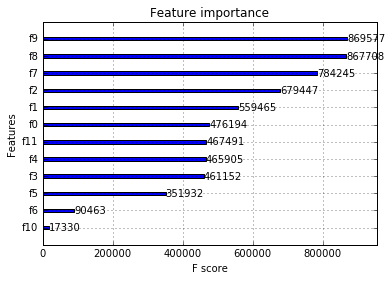

In [52]:
from xgboost import plot_importance
plot_importance(gbm.booster())

In [53]:
print(["f{0} = {1}".format(i, x) for i, x in enumerate(feature_columns)])

['f0 = Min', 'f1 = Hour', 'f2 = Day', 'f3 = Month', 'f4 = Year', 'f5 = DayOfWeek_Conv', 'f6 = PdDistrict_Conv', 'f7 = Address_Conv', 'f8 = X', 'f9 = Y', 'f10 = Corner', 'f11 = Street_Conv', 'f12 = Cell']
